# 1. 정면

## 1) import

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np            # 이미지 처리를 위한 준비작업
print("🌫🛸")

🌫🛸


## 2) 이미지 준비

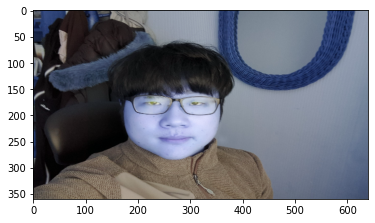

In [2]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

opencv의 특징상 이미지 채널을 BGR로 표기하기 때문에 아래 과정을 통하여 반드시 RGB보정을 해줘야 한다.

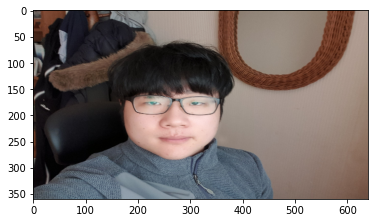

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 3) 얼굴 검출(face detection)

rectangles[[(180, 118) (366, 304)]]


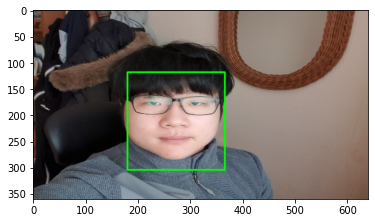

In [4]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- hog detector
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # detector를 이용하여 얼굴의 bounding box 추출
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left() # 좌측 x좌표
    t = dlib_rect.top() # 상단 y좌표
    r = dlib_rect.right() # 우측 x좌표
    b = dlib_rect.bottom() # 하단 y좌표

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 2는 두께

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 4) 얼굴 랜드마크 검출

68


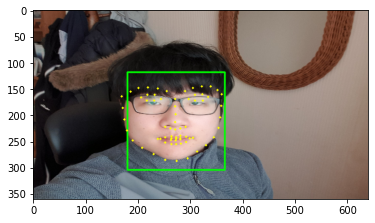

In [5]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) # 랜드마크 포인트 수

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # B, G, R 순이므로 G + R = yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


## 5) 스티커 적용하기

In [6]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) 
    x = landmark[30][0]
    y = landmark[30][1]  
    w = (landmark[30][0] - landmark[2][0]) *2
    h = landmark[48][1] - landmark[36][1] 
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(271, 213)
(x,y) : (271,213)
(w,h) : (194,79)


x, y 값을 연상하기 쉽도록 콧잔등(landmark[30])을 기준으로 지정,   
마찬가지로 landmark를 기준으로 w, h 값을 변경하여 스티커 이미지 범위를 줄임

1. 위치 조정을 위해 기준값을 코 끝(landmark[33])으로 변경   
2. 변화 없었으므로 롤백


In [7]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(79, 194, 3)


상기 지정값을 이용하여 스티커 이미지 resize

In [8]:
refined_x = x - w // 2  # left
refined_y = landmark[1][1]   # top   
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (174,186)


스티커 이미지박스 좌측 상단위치를 눈꼬리(landmark[36])에 맞추기 위해 refined_y 값 지정

1. 위치를 조정하기 위해 top 기준을 landmark[1]로 변경

In [9]:
sticker_area = img_show[refined_y:refined_y+h, refined_x:refined_x+w]
img_show[refined_y:refined_y+h, refined_x:refined_x+w] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

img_show[]내부 각 값들(좌상y : 우하y, 좌상x : 우하x)에 상기 지정한 값들을 사용하여 area 지정.

img_sticker의 rgb값 참조하여 0은 검은색이므로 흰색인 255로 변경

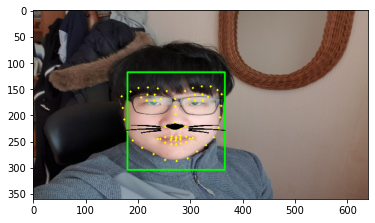

In [10]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

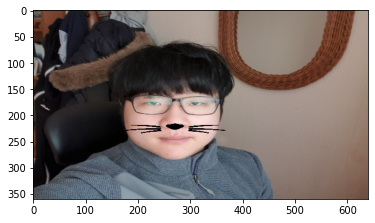

In [11]:
sticker_area = img_bgr[refined_y:refined_y+h, refined_x:refined_x+w]
img_bgr[refined_y:refined_y+h, refined_x:refined_x+w] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

#### 1. 이미지 크기 조절로 인한 수염 짜부현상. 그러나 결과물이 쥐 수염 느낌이나서 부스스한 모습과 어울려 생각보다 마음에 들었으므로 사이즈 조정은 하지 않음.     
#### 단 위치가 원하는 위치보다 약간 위쪽에 위치했으므로 수정 필요.
#### 2. 기준점을 landmark[33]으로 변경했으나 위치 변화 없음
#### 3. refined_y를 landmark[1]로 변경 후 원하는 곳에 위치

 ---

# 2. 측면

## 1) 이미지 준비

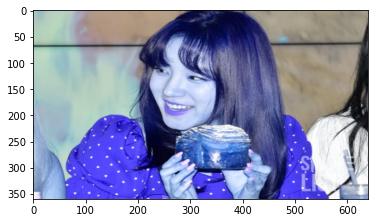

In [12]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image2.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

opencv의 특징상 이미지 채널을 BGR로 표기하기 때문에 아래 과정을 통하여 반드시 RGB보정을 해줘야 한다.

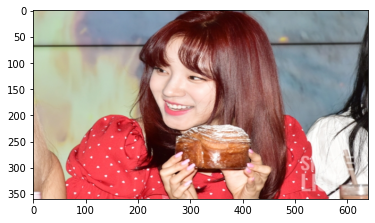

In [13]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2) 얼굴 검출(face detection)

rectangles[[(201, 64) (356, 219)]]


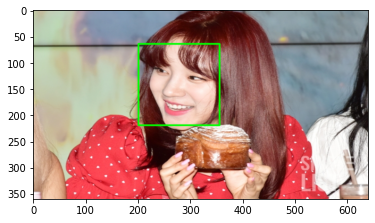

In [14]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- hog detector
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # detector를 이용하여 얼굴의 bounding box 추출
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left() # 좌측 x좌표
    t = dlib_rect.top() # 상단 y좌표
    r = dlib_rect.right() # 우측 x좌표
    b = dlib_rect.bottom() # 하단 y좌표

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)  # 2는 두께

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3) 얼굴 랜드마크 검출

68


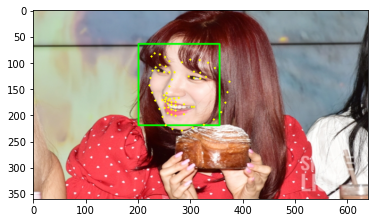

In [15]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) # 랜드마크 포인트 수

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # B, G, R 순이므로 G + R = yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


## 4) 스티커 적용하기

In [16]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) 
    x = landmark[30][0]
    y = landmark[30][1]  
    w = (landmark[30][0] - landmark[2][0]) *2
    h = landmark[48][1] - landmark[36][1] 
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(255, 158)
(x,y) : (255,158)
(w,h) : (66,62)


x, y 값을 연상하기 쉽도록 콧잔등(landmark[30])을 기준으로 지정,   
마찬가지로 landmark를 기준으로 w, h 값을 변경하여 스티커 이미지 범위를 줄임

In [17]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(62, 66, 3)


상기 지정값을 이용하여 스티커 이미지 resize

In [18]:
refined_x = x - w // 2  # left
refined_y = landmark[1][1]  # top   
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (222,129)


스티커 이미지박스 좌측 상단위치를 눈꼬리(landmark[1])에 맞추기 위해 refined_y 값 지정

In [19]:
sticker_area = img_show[refined_y:refined_y+h, refined_x:refined_x+w]
img_show[refined_y:refined_y+h, refined_x:refined_x+w] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

img_show[]내부 각 값들(좌상y : 우하y, 좌상x : 우하x)에 상기 지정한 값들을 사용하여 area 지정.

img_sticker의 rgb값 참조하여 0은 검은색이므로 흰색인 255로 변경

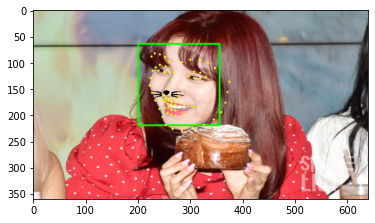

In [20]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

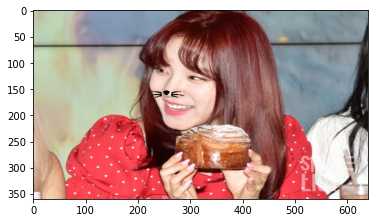

In [21]:
sticker_area = img_bgr[refined_y:refined_y+h, refined_x:refined_x+w]
img_bgr[refined_y:refined_y+h, refined_x:refined_x+w] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 잘 붙었다.

---

# 3. 흑백

## 1) 이미지 준비

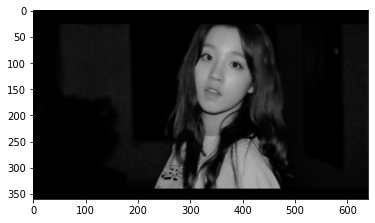

In [22]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image3.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

opencv의 특징상 이미지 채널을 BGR로 표기하기 때문에 아래 과정을 통하여 반드시 RGB보정을 해줘야 한다.

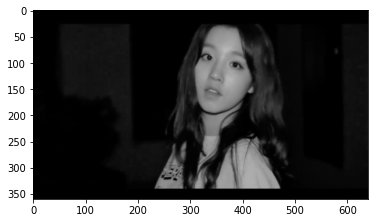

In [23]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2) 얼굴 검출(face detection)

rectangles[[(282, 53) (411, 182)]]


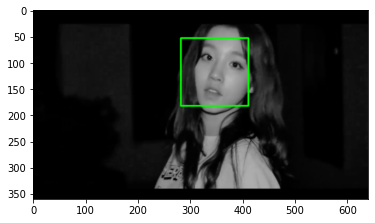

In [24]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- hog detector
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # detector를 이용하여 얼굴의 bounding box 추출
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left() # 좌측 x좌표
    t = dlib_rect.top() # 상단 y좌표
    r = dlib_rect.right() # 우측 x좌표
    b = dlib_rect.bottom() # 하단 y좌표

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)  # 2는 두께

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3) 얼굴 랜드마크 검출

68


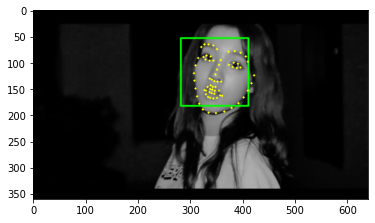

In [25]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) # 랜드마크 포인트 수

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # B, G, R 순이므로 G + R = yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


## 4) 스티커 적용하기

In [26]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) 
    x = landmark[30][0]
    y = landmark[30][1]  
    w = (landmark[30][0] - landmark[2][0]) *2
    h = landmark[48][1] - landmark[36][1] 
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(348, 122)
(x,y) : (348,122)
(w,h) : (82,63)


x, y 값을 연상하기 쉽도록 콧잔등(landmark[30])을 기준으로 지정,   
마찬가지로 landmark를 기준으로 w, h 값을 변경하여 스티커 이미지 범위를 줄임

In [27]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(63, 82, 3)


상기 지정값을 이용하여 스티커 이미지 resize

In [28]:
refined_x = x - w // 2  # left
refined_y = landmark[1][1]  # top   
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (307,105)


스티커 이미지박스 좌측 상단위치를 눈꼬리(landmark[1])에 맞추기 위해 refined_y 값 지정

In [29]:
sticker_area = img_show[refined_y:refined_y+h, refined_x:refined_x+w]
img_show[refined_y:refined_y+h, refined_x:refined_x+w] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

img_show[]내부 각 값들(좌상y : 우하y, 좌상x : 우하x)에 상기 지정한 값들을 사용하여 area 지정.

img_sticker의 rgb값 참조하여 0은 검은색이므로 흰색인 255로 변경

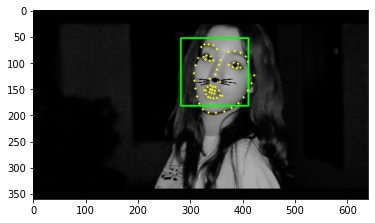

In [30]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

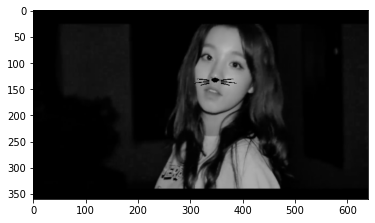

In [31]:
sticker_area = img_bgr[refined_y:refined_y+h, refined_x:refined_x+w]
img_bgr[refined_y:refined_y+h, refined_x:refined_x+w] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 얘도 잘 붙었다

---

# 4. 작은얼굴

## 1) 이미지 준비

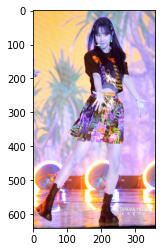

In [32]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image4.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (360, 640))    # 360x640의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

opencv의 특징상 이미지 채널을 BGR로 표기하기 때문에 아래 과정을 통하여 반드시 RGB보정을 해줘야 한다.

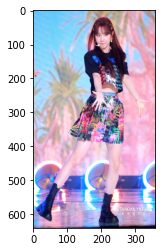

In [33]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2) 얼굴 검출(face detection)

rectangles[[(175, 61) (227, 113)]]


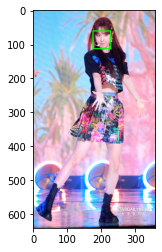

In [34]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- hog detector
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # detector를 이용하여 얼굴의 bounding box 추출
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left() # 좌측 x좌표
    t = dlib_rect.top() # 상단 y좌표
    r = dlib_rect.right() # 우측 x좌표
    b = dlib_rect.bottom() # 하단 y좌표

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)  # 2는 두께

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3) 얼굴 랜드마크 검출

68


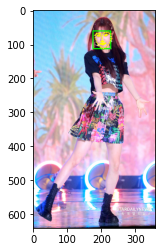

In [35]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) # 랜드마크 포인트 수

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # B, G, R 순이므로 G + R = yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


## 4) 스티커 적용하기

In [36]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) 
    x = landmark[30][0]
    y = landmark[30][1]  
    w = (landmark[30][0] - landmark[2][0]) *2
    h = landmark[48][1] - landmark[36][1] 
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(202, 89)
(x,y) : (202,89)
(w,h) : (36,23)


x, y 값을 연상하기 쉽도록 콧잔등(landmark[30])을 기준으로 지정,   
마찬가지로 landmark를 기준으로 w, h 값을 변경하여 스티커 이미지 범위를 줄임

In [37]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(23, 36, 3)


상기 지정값을 이용하여 스티커 이미지 resize

In [38]:
refined_x = x - w // 2  # left
refined_y = landmark[1][1]  # top   
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (184,81)


스티커 이미지박스 좌측 상단위치를 눈꼬리(landmark[1])에 맞추기 위해 refined_y 값 지정

In [39]:
sticker_area = img_show[refined_y:refined_y+h, refined_x:refined_x+w]
img_show[refined_y:refined_y+h, refined_x:refined_x+w] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

img_show[]내부 각 값들(좌상y : 우하y, 좌상x : 우하x)에 상기 지정한 값들을 사용하여 area 지정.

img_sticker의 rgb값 참조하여 0은 검은색이므로 흰색인 255로 변경

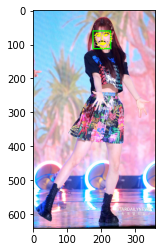

In [40]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

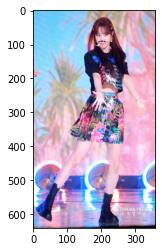

In [41]:
sticker_area = img_bgr[refined_y:refined_y+h, refined_x:refined_x+w]
img_bgr[refined_y:refined_y+h, refined_x:refined_x+w] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 이미지가 작아서 잘 안보이지만 잘 붙은것 같음.

## HOG의 특성상 명암 영향을 크게 받지 않고 윤곽을 식별할수만 있으면 스티커가 잘 붙는것을 확인

# 느낀점
진행 하게 되면서 좌표 평면상에서 각 이미지 배치시 어떤 값을 기준으로 배치가 되는지, 정사각형을 형성할때 점 두개를 기준으로 형성되는것을 배웠다.   
사실 아직도 스티커를 넣어주는 img_show[] 내부에서 왜 [좌상 포인트 좌표, 우하 포인트좌표]가 아닌 [좌상y : 우하y, 좌상x : 우하x]가 되는지는 모르겠다. 위에 자료에는 스티커를 적정 위치로 옮기기 위한 시도를 미처 다 표기하지 못한채 시간이 지나 상세히 적을만큼 기억하지 못해 생략되었다.    때문에 사실상 해결한 단계인 좌표값에 landmark를 이용한 부분부터 표기를 하게 되었다.   

처음 아무것도 이해하지 못하고 시도했을때와 점점 찾아가며 수정이 진행됨에 따라 진행되는 것에서 재미를 느꼈고 프로젝트를 수행하며 항상 생각하게 되는점은 경로를 잘 살펴보고 파일 확장자명도 꼭 확인해야 한다는 것이었다.